In [17]:
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass
from typing import List, Optional, Literal

### Comparing Arithmetic and Wasserstein Averaging of Distributions

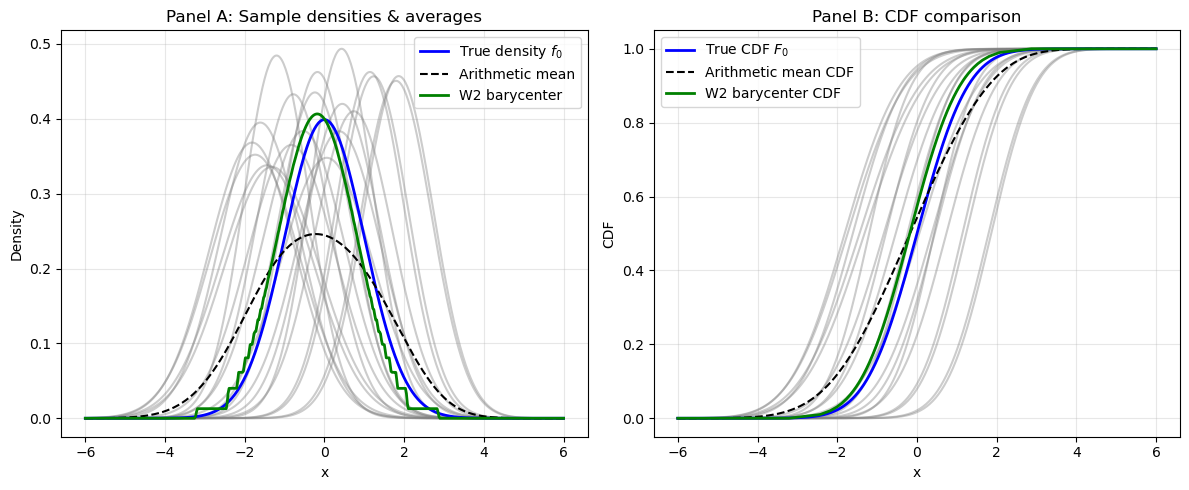

In [18]:
# --- Base distribution ---
f0 = norm.pdf
F0 = norm.cdf
q0 = norm.ppf

# --- Generate random (a,b) for location-scale model ---
n = 20
np.random.seed(42)
a = np.random.uniform(0.8, 1.2, size=n)   # scales
b = np.random.uniform(-2, 2, size=n)      # shifts

x = np.linspace(-6, 6, 500)
densities, cdfs = [], []

for i in range(n):
    fi = (1/a[i]) * f0((x - b[i]) / a[i])
    Fi = norm.cdf((x - b[i]) / a[i])
    densities.append(fi)
    cdfs.append(Fi)

densities = np.array(densities)
cdfs = np.array(cdfs)

# Arithmetic mean density & CDF
f_mean = densities.mean(axis=0)
F_mean = cdfs.mean(axis=0)

# Wasserstein barycenter via quantile averaging
u = np.linspace(0.001, 0.999, 100)
quantiles = np.array([a[i] * q0(u) + b[i] for i in range(n)])
q_bar = np.mean(quantiles, axis=0)

F_bar = np.interp(x, q_bar, np.linspace(0, 1, len(q_bar)))
f_bar = np.gradient(F_bar, x)

# True base
f_true = f0(x)
F_true = F0(x)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: sample densities
for fi in densities:
    axes[0].plot(x, fi, color="gray", alpha=0.4)
axes[0].plot(x, f_true, color="blue", linewidth=2, label="True density $f_0$")
axes[0].plot(x, f_mean, color="black", linestyle="--", label="Arithmetic mean")
axes[0].plot(x, f_bar, color="green", linewidth=2, label="W2 barycenter")
axes[0].set_title("Panel A: Sample densities & averages")
axes[0].set_xlabel("x"); axes[0].set_ylabel("Density")
axes[0].legend(); axes[0].grid(alpha=0.3)


# Panel B: CDFs
for Fi in cdfs:
    axes[1].plot(x, Fi, color="gray", alpha=0.4)
axes[1].plot(x, F_true, color="blue", linewidth=2, label="True CDF $F_0$")
axes[1].plot(x, F_mean, color="black", linestyle="--", label="Arithmetic mean CDF")
axes[1].plot(x, F_bar, color="green", linewidth=2, label="W2 barycenter CDF")
axes[1].set_title("Panel B: CDF comparison")
axes[1].set_xlabel("x"); axes[1].set_ylabel("CDF")
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### WKMeans Clustering Distributions with Different Means and Variances

In [19]:
@dataclass
class WKMeansResult:
    centroids: np.ndarray     # shape (k, p)
    labels: np.ndarray        # shape (n,)
    losses: List[float]
    iter: int

class WassersteinKMeans:
    def __init__(self, n_clusters=2, p=2, max_iter=100, tol=1e-6, random_state=None):
        self.n_clusters = n_clusters
        self.p = p
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids_ = None
        self.labels_ = None
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)
    
    def _wasserstein_empirical(self, alpha: np.ndarray, beta: np.ndarray, p=2):
        """
        Compute empirical Wasserstein-p distance between two empirical measures.

        Parameters
        ----------
        alpha : array-like
            Samples from distribution μ.
        beta : array-like
            Samples from distribution ν.
        p : int
            Order of the Wasserstein distance (default=2).

        Returns
        -------
        Wp : float
            Wasserstein-p distance.
        """
        alpha = np.sort(np.array(alpha))
        beta = np.sort(np.array(beta))

        N = min(len(alpha), len(beta))
        return (np.mean(np.abs(alpha[:N] - beta[:N]) ** p)) ** (1 / p)
    
    def _wasserstein_barycenter(self, samples, p=2):
        """
        Compute the Wasserstein barycenter (centroid) of a list of 1D empirical samples.
        - For p=1: coordinate-wise median of order statistics.
        - For p=2: coordinate-wise mean of order statistics.
        """
        N = len(samples[0])
        # Stack sorted samples
        S = np.vstack([np.sort(s)[:N] for s in samples])
        if p == 1:
            return np.median(S, axis=0)
        else:
            return np.mean(S, axis=0)

    def fit(self, X):
        """
        Run WK-means on a list of empirical distributions (arrays of equal length).
        """
        n_samples = len(X)
        if n_samples < self.n_clusters:
            raise ValueError("Number of samples must be >= number of clusters.")

        # Random initialization of centroids
        self.centroids_ = [X[i] for i in np.random.choice(n_samples, self.n_clusters, replace=False)]
        self.labels_ = np.zeros(n_samples, dtype=int)

        losses = []
        iteration = 0
        while iteration < self.max_iter:
            # Assignment step
            for i, sample in enumerate(X):
                distances = [self._wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
                self.labels_[i] = np.argmin(distances)

            # Update step
            new_centroids = []
            for j in range(self.n_clusters):
                cluster_members = [X[i] for i in range(n_samples) if self.labels_[i] == j]
                if cluster_members:
                    new_centroids.append(self._wasserstein_barycenter(cluster_members, p=self.p))
                else:
                    # Handle empty cluster by reinitializing
                    new_centroids.append(random.choice(X))

            # Check convergence
            shift = sum(
                self._wasserstein_empirical(self.centroids_[j], new_centroids[j], p=self.p)
                for j in range(self.n_clusters)
            )
            self.centroids_ = new_centroids
            
            iteration += 1
            losses.append(shift)

            if shift < self.tol:
                break
        if iteration == self.max_iter:
            print(f"Warning: WK-means algorithm may not converge after {self.max_iter} iterations")

        return WKMeansResult(
            centroids=np.array(self.centroids_),
            labels=self.labels_,
            losses=losses,
            iter=iteration
        )
    
    def predict(self, X):
        """
        Assign new samples to clusters.
        """
        labels = []
        for sample in X:
            distances = [self.wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
            labels.append(np.argmin(distances))
        return np.array(labels)

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Label counts: [30 30]


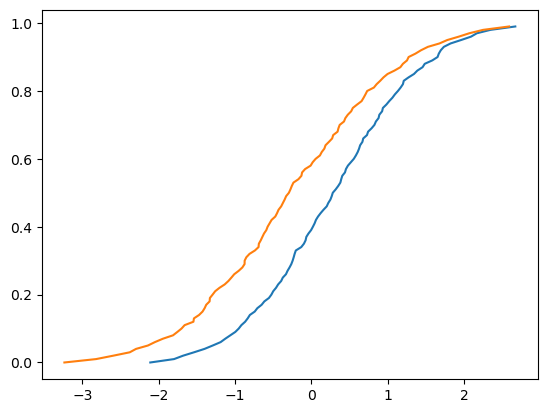

4 [0.4591610328799746, 0.21974828972730792, 0.025130352470695415, 0.0]


In [20]:
# Example: synthetic distributions (two regimes: low vs high variance)
rng = np.random.default_rng(0)

X = []
for _ in range(30):
    X.append(rng.normal(.3, 1, size=100))   # regime 1
for _ in range(30):
    X.append(rng.normal(-.3, 1.2, size=100))   # regime 2

wkmeans = WassersteinKMeans(n_clusters=2, p=1, random_state=42)
result = wkmeans.fit(X)

print("Cluster labels:", result.labels)
print("Label counts:", np.bincount(result.labels))

plt.plot(result.centroids[0], np.arange(len(result.centroids[0])) / len(result.centroids[0]), label='Centroid 1')
plt.plot(result.centroids[1], np.arange(len(result.centroids[1])) / len(result.centroids[1]), label='Centroid 2')
plt.show()

print(result.iter, result.losses)

### Time Series Segmentation and Regime Detection

In [21]:
def segment_time_series(series, window, step):
    """
    Segment a 1D time series into overlapping windows.

    Parameters
    ----------
    series : array-like
        Input time series (e.g., log-returns).
    window : int
        Length of each segment (h1).
    step : int
        Step size (overlap offset, h2).
        - step < window => overlapping segments
        - step = window => disjoint segments
    Returns
    -------
    segments : list of np.ndarray
        List of segments, each of length `window`.
    """
    series = np.asarray(series, dtype=float).ravel()
    n = len(series)
    segments = []
    for start in range(0, n - window + 1, step):
        segment = series[start:start + window]
        segments.append(segment)
    return segments

def plot_regimes_over_price(prices, segments, labels, window, step, title="Market Regimes", times=None):
    """
    Plot price series with coloring by WK-means cluster membership.

    Parameters
    ----------
    prices : array-like
        Full price series.
    segments : list of arrays
        Segmented returns used in WK-means.
    labels : array-like
        Cluster assignment for each segment.
    window : int
        Segment length (same as used in segmenting).
    step : int
        Step size between segments.
    title : str
        Plot title.
    """
    prices = np.asarray(prices)
    if times is None:
        times = np.arange(len(prices))
    fig, ax = plt.subplots(figsize=(12, 5))

    # Default color map: cluster 0 = green, cluster 1 = red, etc.
    cmap = plt.get_cmap("tab10", len(set(labels)))

    # Assign each segment's cluster to its covered price indices
    n_segments = len(segments)
    colors = np.zeros(len(prices))
    counts = np.zeros(len(prices))

    for idx, seg in enumerate(segments):
        start = idx * step
        end = start + window
        if end >= len(prices):
            break
        colors[start:end] += labels[idx]
        counts[start:end] += 1

    # Average cluster assignment where segments overlap
    avg_labels = np.divide(colors, counts, out=np.zeros_like(colors), where=counts > 0)

    # Plot price series, coloring by cluster
    scatter = ax.scatter(
        times,
        prices,
        c=avg_labels,
        cmap=cmap,
        s=10,
        alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel("Time (index)")
    ax.set_ylabel("Price")
    cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(set(labels))))
    cbar.set_label("Cluster")
    plt.show()

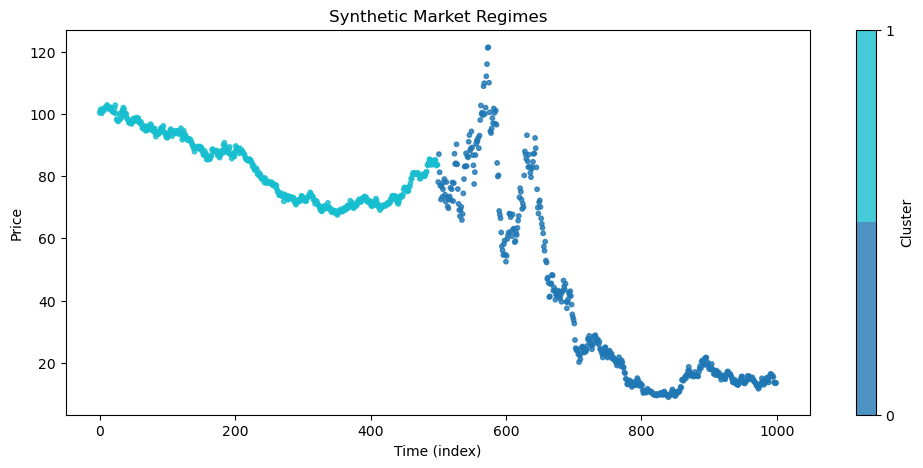

In [22]:
# Synthetic demo: two regimes (low vol vs high vol)
rng = np.random.default_rng(1)
n_points = 1000
returns = np.concatenate([
    rng.normal(0, 0.01, size=n_points // 2),
    rng.normal(0, 0.05, size=n_points // 2),
])
prices = 100 * np.exp(np.cumsum(returns))

# Segment returns
window, step = 50, 25
segments = segment_time_series(returns, window, step)

# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p=2, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, result.labels, window, step, title="Synthetic Market Regimes")

### WK-means Regime Detection in Merton-Jump-Diffusion

In [23]:
def simulate_merton_jump_diffusion(
    T=1.0, N=252, S0=100, 
    mu=0.05, sigma=0.2, 
    lam=1.0, gamma=-0.1, delta=0.2,
    random_state=None
):
    """
    Simulate a Merton jump diffusion price path.

    Parameters
    ----------
    T : float
        Total time horizon.
    N : int
        Number of time steps.
    S0 : float
        Initial price.
    mu : float
        Drift term.
    sigma : float
        Volatility of diffusion part.
    lam : float
        Intensity (expected jumps per unit time).
    gamma : float
        Mean of log(1+V) jump size distribution.
    delta : float
        Std of log(1+V) jump size distribution.
    random_state : int or None
        Random seed for reproducibility.

    Returns
    -------
    times : ndarray
        Time grid.
    prices : ndarray
        Simulated price path.
    """
    if random_state is not None:
        np.random.seed(random_state)

    dt = T / N
    times = np.linspace(0, T, N+1)
    prices = np.zeros(N+1)
    prices[0] = S0

    for t in range(1, N+1):
        Z = np.random.normal(0, 1)
        # Diffusion part
        dW = np.sqrt(dt) * Z
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * dW

        # Jump part
        Nj = np.random.poisson(lam * dt)   # number of jumps
        if Nj > 0:
            jumps = np.sum(np.random.normal(gamma, delta, Nj))
        else:
            jumps = 0.0

        prices[t] = prices[t-1] * np.exp(drift + diffusion + jumps)

    return times, prices

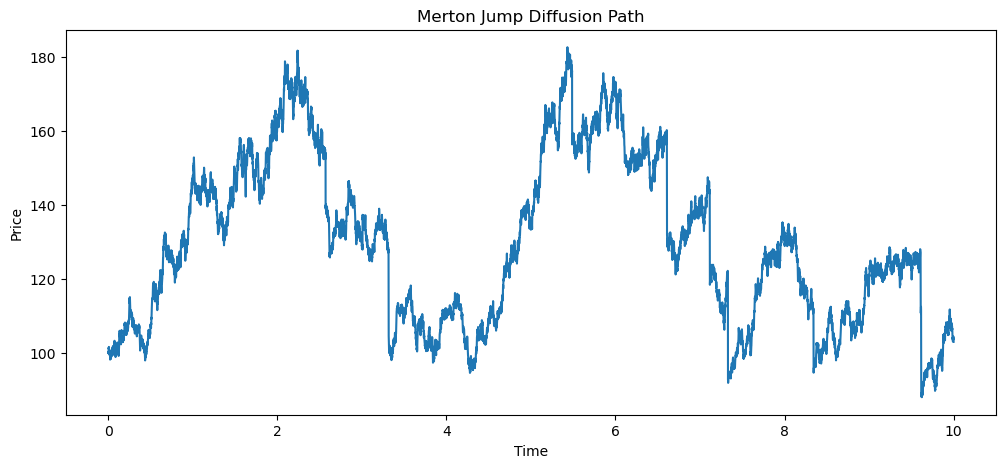

In [24]:
# Simulate a 2-year path with frequent jumps
times, prices = simulate_merton_jump_diffusion(
    T=10.0, N=10000, S0=100,
    mu=0.05, sigma=0.2,
    lam=2.0, gamma=-0.05, delta=0.1,
    random_state=42
)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(times, prices)
plt.title("Merton Jump Diffusion Path")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

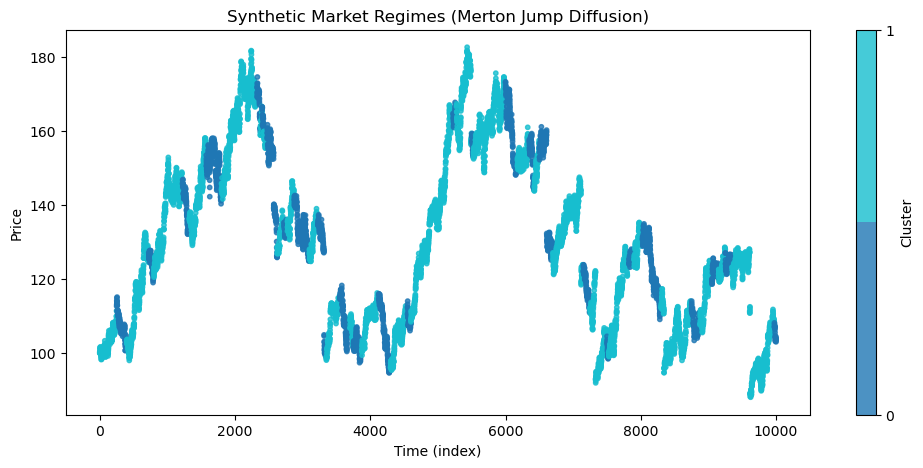

In [25]:
returns = np.diff(np.log(prices))
window, step = 100, 25
segments = segment_time_series(returns, window, step)

# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p=1, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, wkmeans.labels_, window, step, title="Synthetic Market Regimes (Merton Jump Diffusion)")

### Visualizing Clusters in Mean-Variance Space

In [26]:
def segment_stats(segments, use_std=False):
    """
    Compute (mean, variance) or (mean, std) for each segment.
    Returns two numpy arrays of shape (n_segments,).
    """
    segs = [np.asarray(s, dtype=float).ravel() for s in segments]
    means = np.array([s.mean() for s in segs])
    variances = np.array([s.var(ddof=0) for s in segs])
    if use_std:
        return means, np.sqrt(variances)
    return means, variances


def scatter_mean_variance(
    segments,
    labels,
    title="Segments in Mean–Variance Space",
    use_std=False,
    alpha=0.8,
    s=18,
    show_centroids=True,
    legend=True
):
    """
    Scatter plot of segments in (mean, variance) or (mean, std) space, colored by cluster labels.

    Parameters
    ----------
    segments : list[np.ndarray]
        List of return windows (equal length recommended).
    labels : array-like of int
        Cluster assignment for each segment (0..K-1).
    title : str
        Plot title.
    use_std : bool
        If True, y-axis is standard deviation; else variance.
    alpha : float
        Point transparency.
    s : int
        Marker size.
    show_centroids : bool
        If True, overlay cluster centroids computed from (mean, var/std) of members.
    legend : bool
        If True, show legend for clusters.
    """
    labels = np.asarray(labels, dtype=int)
    means, v_or_s = segment_stats(segments, use_std=use_std)

    K = int(labels.max()) + 1
    cmap = plt.get_cmap("tab10", K)

    plt.figure(figsize=(8, 6))
    for k in range(K):
        mask = labels == k
        plt.scatter(
            v_or_s[mask], means[mask],
            s=s, alpha=alpha, color=cmap(k), label=f"Cluster {k}"
        )

    # Optional centroid overlay (in mean–variance space, not Wasserstein barycenters)
    if show_centroids:
        for k in range(K):
            mask = labels == k
            if np.any(mask):
                c_mean = means[mask].mean()
                c_var = v_or_s[mask].mean()
                plt.scatter(
                    [c_var], [c_mean],
                    s=160, edgecolor="black", linewidth=1.2,
                    color=cmap(k), marker="X", zorder=5
                )

    xlab = "Std. Dev." if use_std else "Variance"
    plt.xlabel(xlab)
    plt.ylabel("Mean")
    plt.title(title)
    if legend:
        plt.legend(frameon=False)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

def plot_centroids_cdf(centroids, title="WK-means Centroids CDFs"):
    """
    Plot the CDFs of WK-means centroids.

    Parameters
    ----------
    centroids : np.ndarray
        Array of shape (k, p) where each row is a centroid.
    title : str
        Plot title.
    """
    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("tab10", len(centroids))
    for i, c in enumerate(centroids):
        sorted_c = np.sort(c)
        cdf = np.arange(1, len(c) + 1) / len(c)
        plt.plot(sorted_c, cdf, label=f'Centroid {i}', color=cmap(i))
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

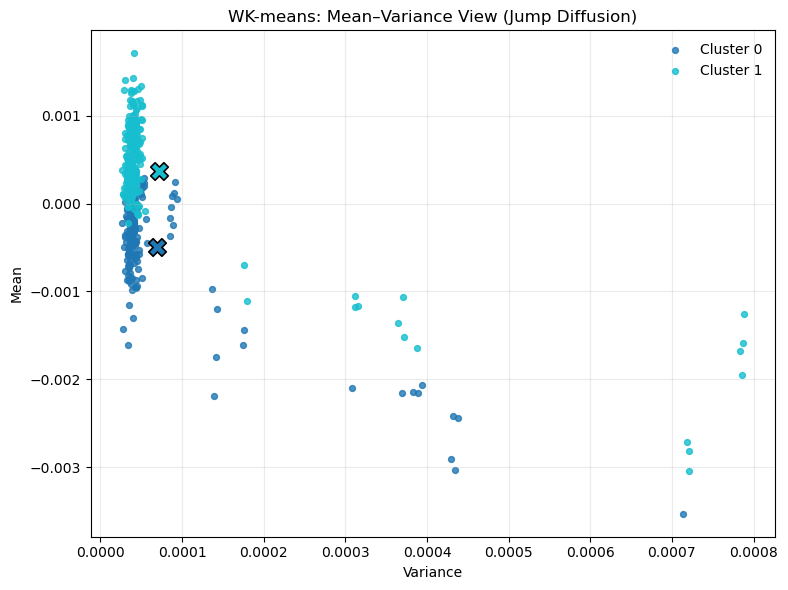

In [27]:
# Assuming you've already built `segments` and fitted `wkmeans` from earlier steps:
scatter_mean_variance(
    segments,
    wkmeans.labels_,
    title="WK-means: Mean–Variance View (Jump Diffusion)",
    use_std=False,         # set True to plot mean–std instead
    show_centroids=True
)

### Detecting S&P 500 Regimes with Hourly Data

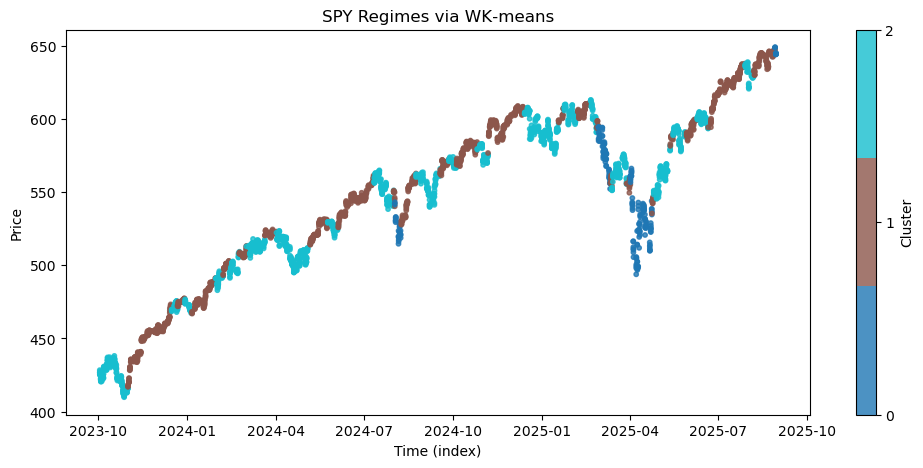

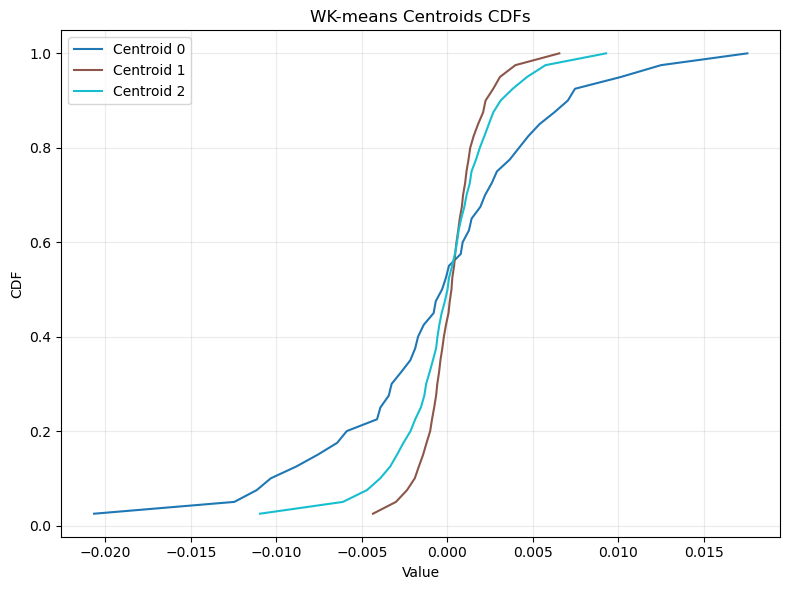

Completed pipeline. Label counts: [ 23 173 134]


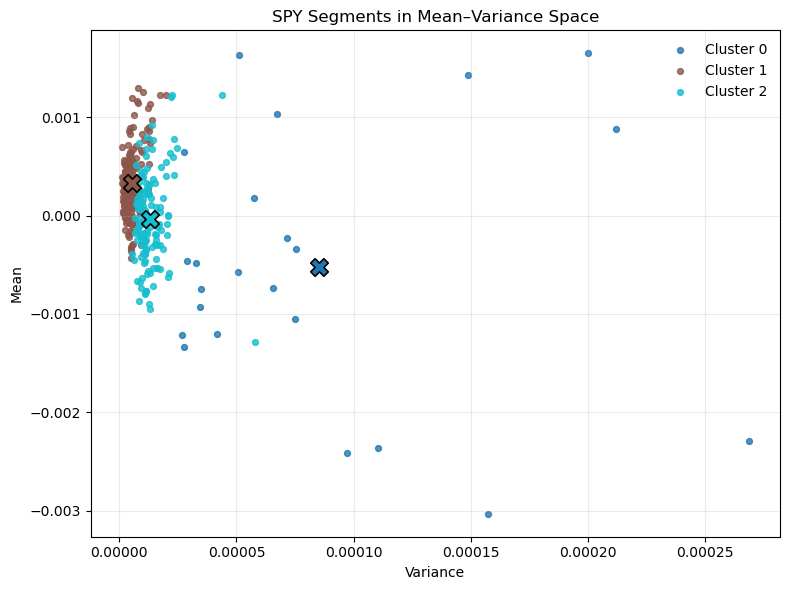

In [28]:
def run_wk_spy_pipeline(start_date="2023-10-01", end_date="2025-09-01", interval="1h", window=40, step=10, k=2, p=1):
    # 1. Download SPY close prices
    spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
    prices = spy["Close"].values.reshape(-1)

    # 2. Compute log returns
    log_returns = np.diff(np.log(prices))
    times = spy.index

    # 3. Segment returns
    segments = segment_time_series(log_returns, window=window, step=step)

    # 4. WK-means clustering
    wk = WassersteinKMeans(n_clusters=k, p=p, random_state=42)
    result = wk.fit(segments)

    # 5. Plot regimes over price
    # Note: prices array is 1 longer than returns; to align, you might drop first window part etc.
    plot_regimes_over_price(prices, segments, result.labels, window, step, title="SPY Regimes via WK‐means", times=times)
    plot_centroids_cdf(result.centroids, title="WK-means Centroids CDFs")

    return {
        "prices": prices,
        "log_returns": log_returns,
        "segments": segments,
        "labels": result.labels,
        "centroids": result.centroids
    }

# Example usage
if __name__ == "__main__":
    result = run_wk_spy_pipeline(p=1, k=3)
    print("Completed pipeline. Label counts:", np.bincount(result["labels"]))
    scatter_mean_variance(
        result["segments"],
        result["labels"],
        title="SPY Segments in Mean–Variance Space",
        use_std=False,
        show_centroids=True
    )

### MK-means Clustering

In [29]:
@dataclass
class MKMeansResult:
    centroids: np.ndarray     # shape (k, p)
    labels: np.ndarray        # shape (n_samples,)
    losses: List[float]       # L2 shift per iteration
    iters: int


class MomentKMeans:
    """
    K-means on the first `p_moments` raw moments of segments.
    - Uses Euclidean distance in moment space (after optional z-scoring).
    - k-means++ initialization.

    Fit input: a list of segments (1D arrays of equal length recommended).
    """

    def __init__(
        self,
        n_clusters: int = 2,
        p_moments: int = 4,
        standardize: bool = True,
        max_iter: int = 100,
        tol: float = 1e-6,
        init: Literal["kmeans++", "random"] = "kmeans++",
        random_state: Optional[int] = None
    ):
        if n_clusters < 2:
            raise ValueError("n_clusters must be >= 2")
        if p_moments < 1:
            raise ValueError("p_moments must be >= 1")
        self.k = n_clusters
        self.p = p_moments
        self.standardize = standardize
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)

        self.centroids_: Optional[np.ndarray] = None
        self.labels_: Optional[np.ndarray] = None
        self._features_: Optional[np.ndarray] = None  # cached feature matrix (n, p)
        
    def _moments_vector(self, x: np.ndarray, p: int) -> np.ndarray:
        """
        First p raw moments of a 1D sample x (finite-length empirical distribution).
        m_n = E[X^n] estimated by sample average.
        Returns shape (p,)
        """
        x = np.asarray(x, dtype=float).ravel()
        return np.array([np.mean(x**n) for n in range(1, p + 1)], dtype=float)


    def _zscore_columns(self, M: np.ndarray, eps: float = 1e-12) -> np.ndarray:
        """Column-wise z-score standardization (mean 0, var 1)."""
        mu = M.mean(axis=0)
        sd = M.std(axis=0)
        return (M - mu) / np.maximum(sd, eps)

    def _build_features(self, segments: List[np.ndarray]) -> np.ndarray:
        F = np.vstack([self._moments_vector(s, self.p) for s in segments]).astype(float)
        return self._zscore_columns(F) if self.standardize else F

    def _init_centroids(self, F: np.ndarray) -> np.ndarray:
        n = F.shape[0]
        if self.init == "random":
            idx = np.random.choice(n, self.k, replace=False)
            return F[idx].copy()

        # k-means++
        centroids = []
        idx0 = random.randrange(n)
        centroids.append(F[idx0])
        for _ in range(1, self.k):
            d2 = np.min(((F[:, None, :] - np.array(centroids)[None, :, :]) ** 2).sum(axis=2), axis=1)
            probs = d2 / d2.sum() if d2.sum() > 0 else np.ones(n) / n
            idx_next = np.random.choice(n, p=probs)
            centroids.append(F[idx_next])
        return np.vstack(centroids)

    def fit(self, segments: List[np.ndarray]) -> MKMeansResult:
        if len(segments) < self.k:
            raise ValueError("Number of samples must be >= n_clusters.")
        F = self._build_features(segments)      # (n, p)
        self._features_ = F
        C = self._init_centroids(F)             # (k, p)
        labels = np.zeros(F.shape[0], dtype=int)
        losses: List[float] = []

        for it in range(1, self.max_iter + 1):
            # assign
            d2 = ((F[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)  # (n, k)
            labels = d2.argmin(axis=1)

            # update
            newC = np.zeros_like(C)
            for j in range(self.k):
                mask = (labels == j)
                if not np.any(mask):
                    # re-seed empty cluster
                    newC[j] = F[np.random.randint(0, F.shape[0])]
                else:
                    newC[j] = F[mask].mean(axis=0)

            # shift (L2 across centroids)
            shift = float(np.linalg.norm(C - newC))
            losses.append(shift)
            C = newC
            if shift < self.tol:
                break

        self.centroids_ = C
        self.labels_ = labels
        return MKMeansResult(C, labels, losses, it)

    def predict(self, segments: List[np.ndarray]) -> np.ndarray:
        if self.centroids_ is None:
            raise RuntimeError("Model not fitted yet.")
        F = self._build_features(segments)
        d2 = ((F[:, None, :] - self.centroids_[None, :, :]) ** 2).sum(axis=2)
        return d2.argmin(axis=1)

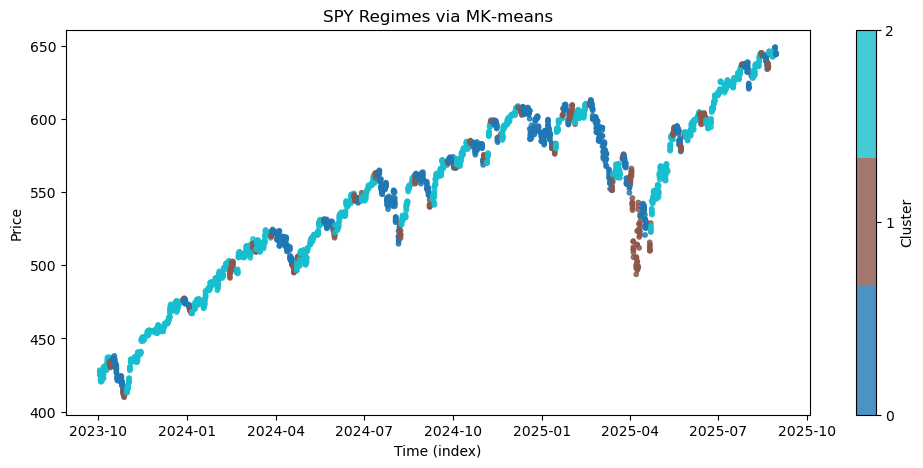

Completed pipeline. Label counts: [120   7 203]


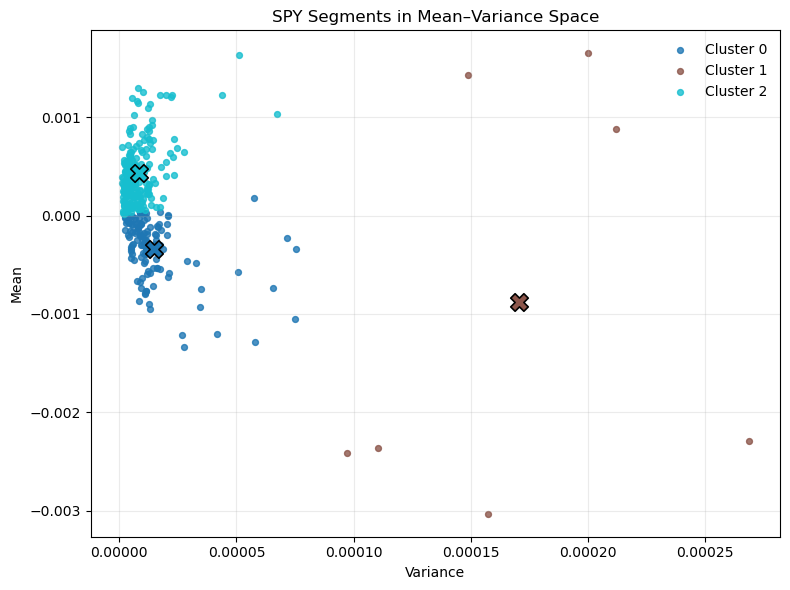

In [30]:
def run_mk_spy_pipeline(start_date="2023-10-01", end_date="2025-09-01", interval="1h", window=40, step=10, k=2, p=4):
    # 1. Download SPY close prices
    spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
    prices = spy["Close"].values.reshape(-1)

    # 2. Compute log returns
    log_returns = np.diff(np.log(prices))
    times = spy.index

    # 3. Segment returns
    segments = segment_time_series(log_returns, window=window, step=step)

    # 4. WK-means clustering
    mk = MomentKMeans(n_clusters=k, p_moments=p, random_state=42)
    result = mk.fit(segments)

    # 5. Plot regimes over price
    # Note: prices array is 1 longer than returns; to align, you might drop first window part etc.
    plot_regimes_over_price(prices, segments, result.labels, window, step, title="SPY Regimes via MK‐means", times=times)

    return {
        "prices": prices,
        "log_returns": log_returns,
        "segments": segments,
        "labels": result.labels,
        "centroids": result.centroids
    }

# Example usage
if __name__ == "__main__":
    result = run_mk_spy_pipeline(p=2, k=3)
    print("Completed pipeline. Label counts:", np.bincount(result["labels"]))
    scatter_mean_variance(
        result["segments"],
        result["labels"],
        title="SPY Segments in Mean–Variance Space",
        use_std=False,
        show_centroids=True
    )

### Hidden Markov Models (HMM) Clustering

In [ ]:
from hmmlearn.hmm import GaussianHMM

# 1. Download data (SPY ETF)
spy = yf.download("SPY", start="2023-10-01", end="2025-09-01", interval="1h", progress=False)
prices = spy["Close"]

# 2. Compute log returns
returns = np.log(prices).diff().dropna()
X = returns.values.reshape(-1, 1)   # hmmlearn expects 2D array

# 3. Fit Gaussian HMM with 2 regimes (Bull/Bear)
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=10000, random_state=42)
model.fit(X)

# 4. Predict hidden states
hidden_states = model.predict(X)

# 5. Inspect regime statistics
for i in range(model.n_components):
    mask = hidden_states == i
    print(f"\nRegime {i}:")
    print(f"  Mean return = {X[mask].mean():.6f}")
    print(f"  Std dev     = {X[mask].std():.6f}")
    print(f"  Days        = {mask.sum()}")

# 6. Plot regimes on price chart
aligned_prices = prices.iloc[1:]
plt.figure(figsize=(12,6))
cmap = plt.get_cmap("tab10", model.n_components)
scatter = plt.scatter(aligned_prices.index, aligned_prices, c=hidden_states, cmap=cmap, s=10, alpha=0.8)
# plt.plot(aligned_prices.index, aligned_prices, 'k-', alpha=0.3)
cbar = plt.colorbar(scatter, ticks=range(len(set(hidden_states))))
cbar.set_label("Cluster")
plt.title("SPY Regime Detection via HMM (hmmlearn)")
plt.show()

### Evaluation Metrics

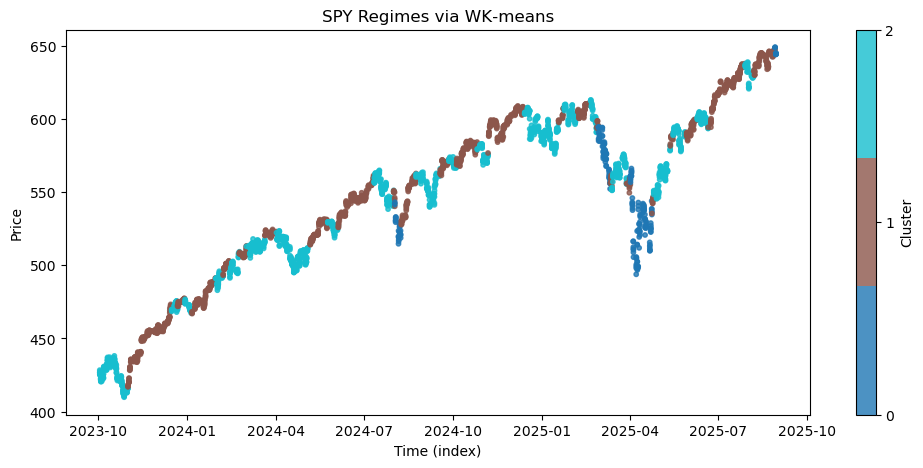

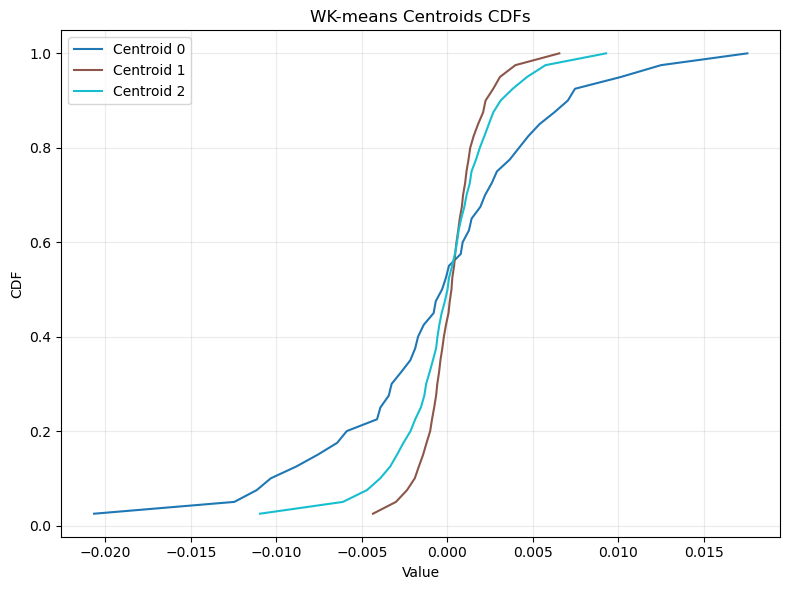

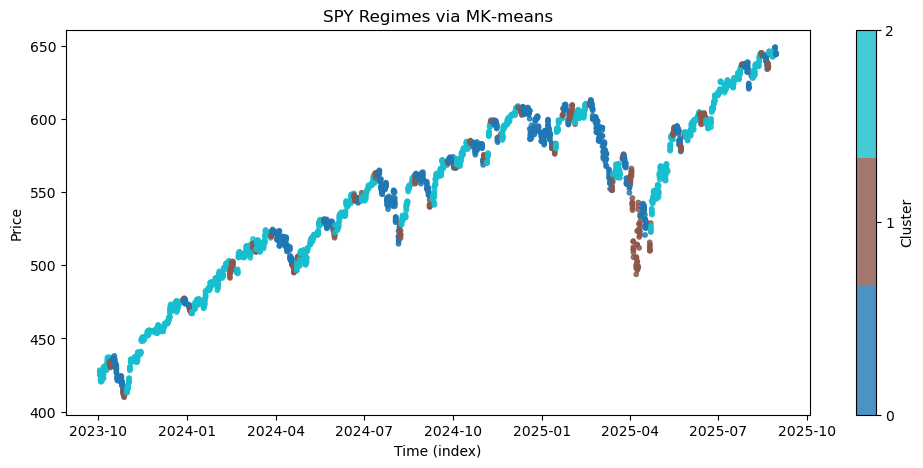

Evaluation:


Computing evaluation metrics...
Computing MMD distributions...

Table 1. Clustering Evaluation Metrics
Algorithm       Davies-Bouldin  Dunn            S̄ₐ       
------------------------------------------------------------
Wasserstein     4.9283          1.101e-01       0.0146    
Moment          1.1230          7.857e-02       0.0356    

Table 2. Self-similarity scores
Algorithm       C1             C2             C3            
------------------------------------------------------------
Wasserstein     0.0163         0.0038         0.0053        
Moment          0.0036         0.0305         0.0034        


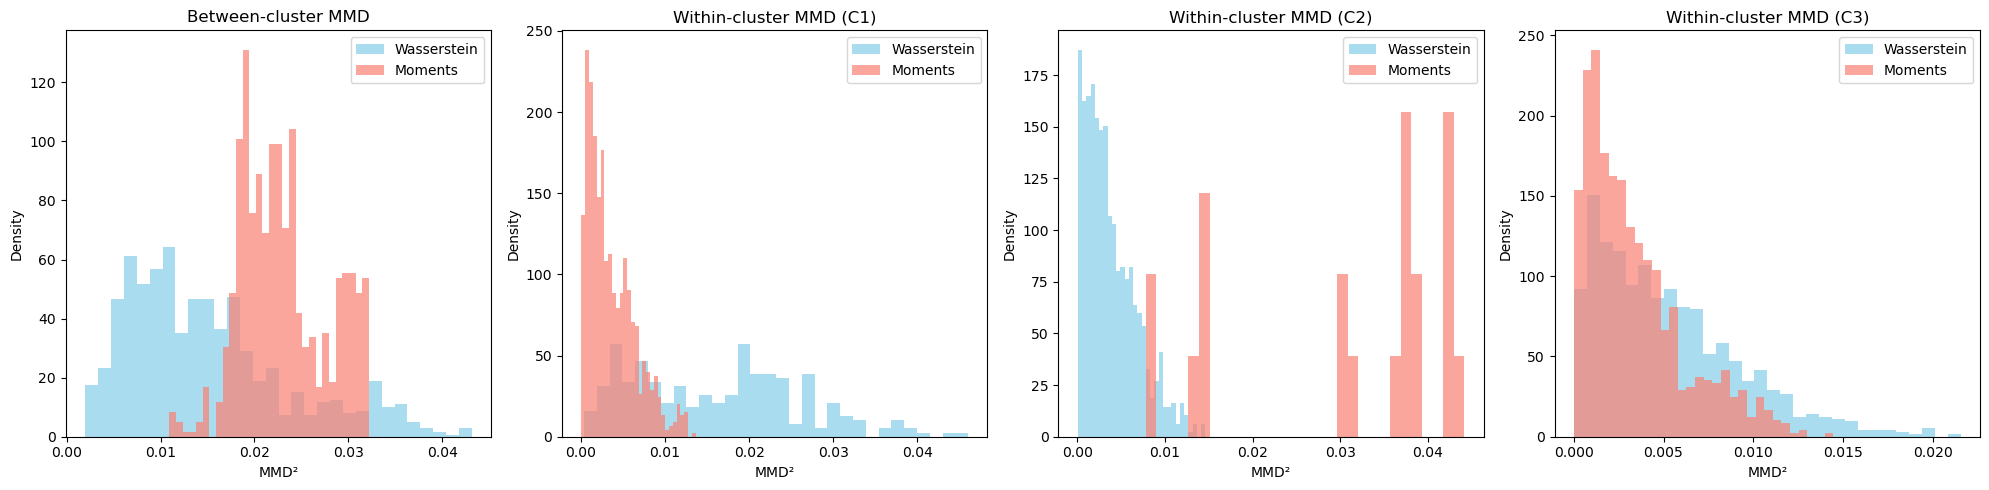

In [42]:
"""
Complete self-contained evaluation script for comparing WK-means and MK-means clustering.
This file includes all necessary classes and functions, with proper handling of list/array inputs.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance
from typing import List, Tuple, Dict, Optional, Union
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

class ClusteringEvaluator:
    """
    Comprehensive evaluation framework for comparing WK-means and MK-means clustering.
    Implements Davies-Bouldin, Dunn, Silhouette, and MMD-based metrics.
    """
    
    def __init__(self):
        self.results = {}
    
    def _ensure_numpy(self, data: Union[List, np.ndarray]) -> np.ndarray:
        """Convert to numpy array if needed."""
        if isinstance(data, list):
            return np.array(data)
        return data
    
    def davies_bouldin_index(self, segments: Union[List, np.ndarray], 
                            labels: Union[List, np.ndarray], 
                            centroids: Union[List, np.ndarray], 
                            distance_func=None) -> float:
        """
        Calculate Davies-Bouldin index (lower is better).
        """
        # Convert to numpy arrays
        segments = self._ensure_numpy(segments)
        labels = self._ensure_numpy(labels)
        centroids = self._ensure_numpy(centroids)
        
        n_clusters = len(np.unique(labels))
        
        if distance_func is None:
            # For moment-based centroids
            def compute_moments(seg, p):
                """Compute first p raw moments"""
                seg = np.asarray(seg, dtype=float).ravel()
                return np.array([np.mean(seg**n) for n in range(1, p + 1)])
            
            # Check if centroids are moment-based
            if centroids.shape[1] <= 10:  # Likely moment-based
                p = centroids.shape[1]
                def distance_func(seg, centroid):
                    if seg.shape == centroid.shape:
                        return np.linalg.norm(seg - centroid)
                    else:
                        seg_moments = compute_moments(seg, p)
                        return np.linalg.norm(seg_moments - centroid)
            else:
                distance_func = lambda x, y: np.linalg.norm(x - y)
        
        # Calculate intra-cluster distances
        intra_dists = np.zeros(n_clusters)
        for i in range(n_clusters):
            mask = labels == i
            cluster_segments = segments[mask]
            if len(cluster_segments) > 0:
                dists = [distance_func(seg, centroids[i]) for seg in cluster_segments]
                intra_dists[i] = np.mean(dists)
        
        # Calculate DB index
        db_values = []
        for i in range(n_clusters):
            max_ratio = 0
            for j in range(n_clusters):
                if i != j:
                    inter_dist = distance_func(centroids[i], centroids[j])
                    if inter_dist > 0:
                        ratio = (intra_dists[i] + intra_dists[j]) / inter_dist
                        max_ratio = max(max_ratio, ratio)
            db_values.append(max_ratio)
        
        return np.mean(db_values) if db_values else 0.0
    
    def dunn_index(self, segments: Union[List, np.ndarray], 
                   labels: Union[List, np.ndarray], 
                   distance_func=None) -> float:
        """
        Calculate Dunn index (higher is better).
        """
        segments = self._ensure_numpy(segments)
        labels = self._ensure_numpy(labels)
        
        n_clusters = len(np.unique(labels))
        
        if distance_func is None:
            distance_func = lambda x, y: np.linalg.norm(x - y)
        
        # Calculate minimum inter-cluster distance
        min_inter_dist = float('inf')
        for i in range(n_clusters):
            for j in range(i+1, n_clusters):
                cluster_i = segments[labels == i]
                cluster_j = segments[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    # Sample for efficiency
                    n_samples = min(50, len(cluster_i), len(cluster_j))
                    if n_samples > 0:
                        idx_i = np.random.choice(len(cluster_i), min(n_samples, len(cluster_i)), replace=False)
                        idx_j = np.random.choice(len(cluster_j), min(n_samples, len(cluster_j)), replace=False)
                        
                        for seg_i in cluster_i[idx_i]:
                            for seg_j in cluster_j[idx_j]:
                                dist = distance_func(seg_i, seg_j)
                                min_inter_dist = min(min_inter_dist, dist)
        
        # Calculate maximum intra-cluster distance
        max_intra_dist = 0
        for i in range(n_clusters):
            cluster_segments = segments[labels == i]
            if len(cluster_segments) > 1:
                n_samples = min(50, len(cluster_segments))
                indices = np.random.choice(len(cluster_segments), n_samples, replace=False)
                sampled = cluster_segments[indices]
                
                for j in range(len(sampled)):
                    for k in range(j+1, len(sampled)):
                        dist = distance_func(sampled[j], sampled[k])
                        max_intra_dist = max(max_intra_dist, dist)
        
        if max_intra_dist == 0 or min_inter_dist == float('inf'):
            return 0.0
        
        return min_inter_dist / max_intra_dist
    
    def silhouette_coefficient(self, segments: Union[List, np.ndarray], 
                              labels: Union[List, np.ndarray], 
                              sample_size: int = None, alpha: float = 0.2) -> float:
        """
        Calculate average Silhouette coefficient.
        """
        segments = self._ensure_numpy(segments)
        labels = self._ensure_numpy(labels)
        
        n_samples = len(segments)
        n_clusters = len(np.unique(labels))
        
        if n_clusters == 1:
            return 0.0
        
        # Sample for efficiency
        if sample_size is None:
            sample_size = int(alpha * n_samples)
        sample_size = min(sample_size, n_samples)
        
        if sample_size == 0:
            return 0.0
        
        indices = np.random.choice(n_samples, sample_size, replace=False)
        sampled_segments = segments[indices]
        sampled_labels = labels[indices]
        
        silhouette_scores = []
        
        for i, seg in enumerate(sampled_segments):
            label = sampled_labels[i]
            
            # Calculate a_i
            same_cluster = sampled_segments[sampled_labels == label]
            if len(same_cluster) > 1:
                a_i = np.mean([np.linalg.norm(seg - other) 
                              for other in same_cluster if not np.array_equal(other, seg)])
            else:
                a_i = 0
            
            # Calculate b_i
            b_i = float('inf')
            for other_label in np.unique(sampled_labels):
                if other_label != label:
                    other_cluster = sampled_segments[sampled_labels == other_label]
                    if len(other_cluster) > 0:
                        mean_dist = np.mean([np.linalg.norm(seg - other) 
                                           for other in other_cluster])
                        b_i = min(b_i, mean_dist)
            
            if b_i == float('inf'):
                s_i = 0
            else:
                s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
            
            silhouette_scores.append(s_i)
        
        return np.mean(silhouette_scores) if silhouette_scores else 0.0
    
    def mmd_gaussian_kernel(self, X: np.ndarray, Y: np.ndarray, 
                           sigma: float = 0.1) -> float:
        """
        Calculate Maximum Mean Discrepancy with Gaussian kernel.
        """
        X = self._ensure_numpy(X)
        Y = self._ensure_numpy(Y)
        
        m, n = len(X), len(Y)
        
        if m == 0 or n == 0:
            return 0.0
        
        # Reshape if needed
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
        
        # Kernel computations
        K_XX = np.exp(-cdist(X, X, 'euclidean')**2 / (2 * sigma**2))
        K_YY = np.exp(-cdist(Y, Y, 'euclidean')**2 / (2 * sigma**2))
        K_XY = np.exp(-cdist(X, Y, 'euclidean')**2 / (2 * sigma**2))
        
        # MMD^2 estimate
        mmd2 = (np.sum(K_XX) / (m * m) + 
                np.sum(K_YY) / (n * n) - 
                2 * np.sum(K_XY) / (m * n))
        
        return np.sqrt(max(0, mmd2))
    
    def compute_mmd_distributions(self, segments: Union[List, np.ndarray], 
                                 labels: Union[List, np.ndarray],
                                 n_samples: int = 1000) -> Dict:
        """
        Compute between-cluster and within-cluster MMD distributions.
        """
        segments = self._ensure_numpy(segments)
        labels = self._ensure_numpy(labels)
        
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels)
        
        # Between-cluster MMD (only for first two clusters)
        between_mmd = []
        if n_clusters >= 2:
            cluster_0 = segments[labels == unique_labels[0]]
            cluster_1 = segments[labels == unique_labels[1]]
            
            n_samples_between = min(n_samples, len(cluster_0) * len(cluster_1))
            
            for _ in range(n_samples_between):
                idx_0 = np.random.randint(0, len(cluster_0))
                idx_1 = np.random.randint(0, len(cluster_1))
                
                x = cluster_0[idx_0]
                y = cluster_1[idx_1]
                
                mmd = self.mmd_gaussian_kernel(x, y)
                between_mmd.append(mmd)
        
        # Within-cluster MMD
        within_mmd = {}
        for i, label in enumerate(unique_labels):
            cluster = segments[labels == label]
            if len(cluster) > 1:
                n_samples_within = min(n_samples, len(cluster) * (len(cluster) - 1) // 2)
                
                within_mmd[i] = []
                for _ in range(n_samples_within):
                    idx1, idx2 = np.random.choice(len(cluster), 2, replace=False)
                    x = cluster[idx1]
                    y = cluster[idx2]
                    mmd = self.mmd_gaussian_kernel(x, y)
                    within_mmd[i].append(mmd)
        
        return {'between': between_mmd, 'within': within_mmd}
    
    def similarity_score(self, mmd_values: List[float]) -> float:
        """Calculate similarity score from MMD distribution."""
        if len(mmd_values) == 0:
            return 0.0
        return np.mean(mmd_values)
    
    def plot_mmd_histograms(self, wk_mmd: Dict, mk_mmd: Dict):
        """Plot MMD distribution histograms."""
        # Determine number of subplots needed
        n_clusters = max(len(wk_mmd.get('within', {})), len(mk_mmd.get('within', {})))
        n_plots = n_clusters + 1  # Between-cluster + all within-cluster plots
        
        # Create appropriate subplot layout
        if n_plots <= 4:
            fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
        else:
            # For many clusters, use 2 rows
            n_cols = (n_plots + 1) // 2
            fig, axes = plt.subplots(2, n_cols, figsize=(5*n_cols, 10))
            axes = axes.flatten()
        
        if n_plots == 1:
            axes = [axes]
        
        # Between-cluster MMD
        ax = axes[0]
        if len(wk_mmd.get('between', [])) > 0:
            ax.hist(wk_mmd['between'], bins=30, alpha=0.7, label='Wasserstein', 
                    color='skyblue', density=True)
        if len(mk_mmd.get('between', [])) > 0:
            ax.hist(mk_mmd['between'], bins=30, alpha=0.7, label='Moments', 
                    color='salmon', density=True)
        ax.set_xlabel('MMD²')
        ax.set_ylabel('Density')
        ax.set_title('Between-cluster MMD')
        ax.legend()
        
        # Within-cluster MMD plots for ALL clusters
        for cluster_idx in range(n_clusters):
            plot_idx = cluster_idx + 1
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                
                if cluster_idx in wk_mmd.get('within', {}) and len(wk_mmd['within'][cluster_idx]) > 0:
                    ax.hist(wk_mmd['within'][cluster_idx], bins=30, alpha=0.7, 
                           label='Wasserstein', color='skyblue', density=True)
                if cluster_idx in mk_mmd.get('within', {}) and len(mk_mmd['within'][cluster_idx]) > 0:
                    ax.hist(mk_mmd['within'][cluster_idx], bins=30, alpha=0.7, 
                           label='Moments', color='salmon', density=True)
                
                ax.set_xlabel('MMD²')
                ax.set_ylabel('Density')
                ax.set_title(f'Within-cluster MMD (C{cluster_idx+1})')
                ax.legend()
        
        # Hide unused subplots if any
        for i in range(n_plots, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

def evaluate_both_methods(wk_pipeline_result: Dict, mk_pipeline_result: Dict):
    """
    Evaluate and compare WK-means and MK-means clustering results.
    """
    # Initialize evaluator
    evaluator = ClusteringEvaluator()
    
    # Extract and convert data
    wk_segments = evaluator._ensure_numpy(wk_pipeline_result['segments'])
    wk_labels = evaluator._ensure_numpy(wk_pipeline_result['labels'])
    wk_centroids = evaluator._ensure_numpy(wk_pipeline_result['centroids'])
    
    mk_segments = evaluator._ensure_numpy(mk_pipeline_result['segments'])
    mk_labels = evaluator._ensure_numpy(mk_pipeline_result['labels'])
    mk_centroids = evaluator._ensure_numpy(mk_pipeline_result['centroids'])
    
    print("\nComputing evaluation metrics...")
    
    # Calculate Traditional Metrics
    wk_db = evaluator.davies_bouldin_index(wk_segments, wk_labels, wk_centroids)
    mk_db = evaluator.davies_bouldin_index(mk_segments, mk_labels, mk_centroids)
    
    wk_dunn = evaluator.dunn_index(wk_segments, wk_labels)
    mk_dunn = evaluator.dunn_index(mk_segments, mk_labels)
    
    wk_silhouette = evaluator.silhouette_coefficient(wk_segments, wk_labels, alpha=0.2)
    mk_silhouette = evaluator.silhouette_coefficient(mk_segments, mk_labels, alpha=0.2)
    
    # Calculate MMD-based Metrics
    print("Computing MMD distributions...")
    
    wk_mmd = evaluator.compute_mmd_distributions(wk_segments, wk_labels, n_samples=1000)
    mk_mmd = evaluator.compute_mmd_distributions(mk_segments, mk_labels, n_samples=1000)
    
    # Get self-similarity scores
    n_clusters = max(len(np.unique(wk_labels)), len(np.unique(mk_labels)))
    
    # Print Table 1
    print("\n" + "="*60)
    print("Table 1. Clustering Evaluation Metrics")
    print("="*60)
    print(f"{'Algorithm':<15} {'Davies-Bouldin':<15} {'Dunn':<15} {'S̄ₐ':<10}")
    print("-"*60)
    print(f"{'Wasserstein':<15} {wk_db:<15.4f} {wk_dunn:<15.3e} {wk_silhouette:<10.4f}")
    print(f"{'Moment':<15} {mk_db:<15.4f} {mk_dunn:<15.3e} {mk_silhouette:<10.4f}")
    print("="*60)
    
    # Print Table 2
    print("\n" + "="*60)
    print("Table 2. Self-similarity scores")
    print("="*60)
    
    # Build header
    header = f"{'Algorithm':<15}"
    for i in range(n_clusters):
        header += f" {'C' + str(i+1):<14}"
    print(header)
    print("-"*60)
    
    # WK-means row
    wk_row = f"{'Wasserstein':<15}"
    for i in range(n_clusters):
        score = evaluator.similarity_score(wk_mmd['within'].get(i, []))
        wk_row += f" {score:<14.4f}" if score > 0 else f" {'N/A':<14}"
    print(wk_row)
    
    # MK-means row
    mk_row = f"{'Moment':<15}"
    for i in range(n_clusters):
        score = evaluator.similarity_score(mk_mmd['within'].get(i, []))
        mk_row += f" {score:<14.4f}" if score > 0 else f" {'N/A':<14}"
    print(mk_row)
    print("="*60)
    
    # Plot histograms
    evaluator.plot_mmd_histograms(wk_mmd, mk_mmd)
    
    return {
        'metrics': pd.DataFrame({
            'Algorithm': ['Wasserstein', 'Moment'],
            'Davies-Bouldin': [wk_db, mk_db],
            'Dunn': [wk_dunn, mk_dunn],
            'Silhouette': [wk_silhouette, mk_silhouette]
        }),
        'mmd_distributions': {'wk': wk_mmd, 'mk': mk_mmd}
    }

if __name__ == "__main__":
    wk_result = run_wk_spy_pipeline(p=1, k=3)  # Your WK-means pipeline
    mk_result = run_mk_spy_pipeline(p=2, k=3)  # Your MK-means pipeline  
    print("Evaluation:\n")
    results = evaluate_both_methods(wk_result, mk_result)